# Covid #

### 1. Import relevant libraries & data###

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas
%matplotlib inline
import requests
import pandas as pd
import json
import ast

In [14]:
print(sns.__version__)

original_data = pd.read_csv("COVID-19_Case_Surveillance_Public_Use_Data_with_Geography.csv")
# 50s

0.11.2


/Users/junghwankim/opt/anaconda3/envs/p1_covid/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
len(original_data)

28652764

In [3]:
import pandas as pd
from sodapy import Socrata

client = Socrata("data.cdc.gov", None)
#results = client.get("n8mc-b4w4.json?case_month=2021-08", limit=50000)#50000000
results = client.get("n8mc-b4w4", limit=5000000, case_month="2021-08")#50000000
original_data = pd.DataFrame.from_records(results)
# 2 min 
%time

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


In [14]:
len(original_data)

2946056

In [4]:
client = Socrata("data.cdc.gov", None)
#results = client.get("n8mc-b4w4.json?case_month=2021-08", limit=50000)#50000000
results = client.get("n8mc-b4w4", limit=5000000, case_month="2021-09")#50000000
original_data = pd.DataFrame.from_records(results)
print(len(original_data))
# 55s
%time

1099759
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs


In [8]:
from datetime import date

today = date.today()
print(today)

2021-10-06


### 2. Data preprocessing ###

#### 2.1 Age & Sex data ####

In [16]:
# Slice related columns
age_sex_data = original_data[["case_month", "age_group", "sex"]]
print("Original age, sex data size:",len(age_sex_data))

# Drop NA
age_sex_data = age_sex_data.dropna()
# Drop "Missing" and "Unknown" rows in age_group and sex
age_sex_data = age_sex_data[age_sex_data['age_group'] != "Missing"]
age_sex_data = age_sex_data[age_sex_data['age_group'] != "Unknown"]
age_sex_data = age_sex_data[age_sex_data['sex'] != "Missing"]
age_sex_data = age_sex_data[age_sex_data['sex'] != "Unknown"]
#age_sex_data = age_sex_data[age_sex_data['sex'] != "Other"]
print("After remove missing values:",len(age_sex_data))

age_sex_data.head()

Original age, sex data size: 28652764
After remove missing values: 27337748


,case_month,age_group,sex
4,2020-12,0 - 17 years,Female
5,2020-12,0 - 17 years,Female
6,2020-07,0 - 17 years,Female
7,2021-05,0 - 17 years,Female
8,2020-11,0 - 17 years,Female


In [17]:
# Sorting data by case_month
age_sex_data = age_sex_data.sort_values('case_month')

age_sex_data.head()

,case_month,age_group,sex
3237044,2020-01,0 - 17 years,Female
18605309,2020-01,65+ years,Female
21028833,2020-01,50 to 64 years,Male
9885861,2020-01,18 to 49 years,Female
13972270,2020-01,65+ years,Female


In [18]:
age_sex_data["sex_age"] = age_sex_data["sex"].astype(str) +"_"+ age_sex_data["age_group"].astype(str)
age_sex_data = age_sex_data[["case_month", "sex_age"]]

In [19]:
age_sex_data.head()

,case_month,sex_age
3237044,2020-01,Female_0 - 17 years
18605309,2020-01,Female_65+ years
21028833,2020-01,Male_50 to 64 years
9885861,2020-01,Female_18 to 49 years
13972270,2020-01,Female_65+ years


In [20]:
age_sex_data_group_by = age_sex_data.groupby(['case_month', 'sex_age']).size().reset_index(name='counts')

In [21]:
age_sex_data_group_by

,case_month,sex_age,counts
0,2020-01,Female_0 - 17 years,11
1,2020-01,Female_18 to 49 years,280
2,2020-01,Female_50 to 64 years,73
3,2020-01,Female_65+ years,280
4,2020-01,Male_0 - 17 years,12
...,...,...,...
154,2021-08,Female_65+ years,610
155,2021-08,Male_0 - 17 years,2314
156,2021-08,Male_18 to 49 years,9045
157,2021-08,Male_50 to 64 years,1635


In [22]:
# Convert dataframe to pivot table
age_sex_data_group_by = age_sex_data_group_by.pivot(index="case_month", columns="sex_age", values="counts")
# Replace NaN to 0
age_sex_data_group_by = age_sex_data_group_by.fillna(0)
# Convert float type to int
age_sex_data_group_by = age_sex_data_group_by.astype(int)
age_sex_data_group_by

sex_age,Female_0 - 17 years,Female_18 to 49 years,Female_50 to 64 years,Female_65+ years,Male_0 - 17 years,Male_18 to 49 years,Male_50 to 64 years,Male_65+ years,Other_18 to 49 years
case_month,,,,,,,,,
2020-01,11,280,73,280,12,174,125,260,0
2020-02,0,347,219,295,0,300,240,261,0
2020-03,1991,85585,48528,33800,2424,82756,50549,36529,0
2020-04,9884,184379,96446,102176,10581,171754,97336,82401,0
2020-05,20448,178968,71625,69090,21055,171074,71005,49342,0
2020-06,36733,275876,80591,55877,35993,251360,76464,43999,0
2020-07,66617,424418,131561,84452,65027,377731,121499,69154,0
2020-08,52351,313363,97426,68844,51354,284145,91110,55285,0
2020-09,49262,296784,89627,66455,49123,269657,83933,53875,0


In [23]:
# Drop Other gender since there's not enough data
age_sex_data_group_by = age_sex_data_group_by.drop(['Other_18 to 49 years'], axis=1)

In [24]:
age_sex_data_group_by

sex_age,Female_0 - 17 years,Female_18 to 49 years,Female_50 to 64 years,Female_65+ years,Male_0 - 17 years,Male_18 to 49 years,Male_50 to 64 years,Male_65+ years
case_month,,,,,,,,
2020-01,11,280,73,280,12,174,125,260
2020-02,0,347,219,295,0,300,240,261
2020-03,1991,85585,48528,33800,2424,82756,50549,36529
2020-04,9884,184379,96446,102176,10581,171754,97336,82401
2020-05,20448,178968,71625,69090,21055,171074,71005,49342
2020-06,36733,275876,80591,55877,35993,251360,76464,43999
2020-07,66617,424418,131561,84452,65027,377731,121499,69154
2020-08,52351,313363,97426,68844,51354,284145,91110,55285
2020-09,49262,296784,89627,66455,49123,269657,83933,53875


In [25]:
age_sex_data_group_by.to_csv('age_sex_data_group_by.csv',index_label=age_sex_data_group_by.columns.name)

#### 2.2 Heavy symtom ####

In [26]:
# Slice related columns
heavy_symtom_data = original_data[["case_month", "icu_yn"]]
print("Original heavy symtom data size:",len(heavy_symtom_data))

# Drop NA
heavy_symtom_data = heavy_symtom_data.dropna()
# Drop "Missing" and "Unknown" rows in icu_yn column
heavy_symtom_data = heavy_symtom_data[heavy_symtom_data['icu_yn'] != "Missing"]
heavy_symtom_data = heavy_symtom_data[heavy_symtom_data['icu_yn'] != "Unknown"]
print("After remove missing values:",len(heavy_symtom_data))

# Sorting data by case_month
heavy_symtom_data = heavy_symtom_data.sort_values('case_month')

# Group by heavy symtom status
heavy_symtom_data_groupby = heavy_symtom_data.groupby(['case_month', 'icu_yn']).size().reset_index(name='counts')

# Convert dataframe to pivot table
heavy_symtom_data_groupby = heavy_symtom_data_groupby.pivot(index="case_month", columns="icu_yn", values="counts")

# Export dataframe to csv file
heavy_symtom_data_groupby.to_csv('heavy_symtom_data_groupby.csv',index_label=heavy_symtom_data_groupby.columns.name)

Original heavy symtom data size: 28652764
After remove missing values: 1702859


#### 2.3 States ####

In [27]:
# Slice related columns
states_data = original_data[["case_month", "res_state"]]
print("Original states data size:",len(states_data))

# Drop NA
states_data = states_data.dropna()
# Drop "Missing" and "Unknown" rows in icu_yn column
states_data = states_data[states_data['res_state'] != "Missing"]
states_data = states_data[states_data['res_state'] != "Unknown"]
print("After remove missing values:",len(states_data))

# Sorting data by case_month
states_data = states_data.sort_values('case_month')

# Group by heavy symtom status
states_data_groupby = states_data.groupby(['case_month', 'res_state']).size().reset_index(name='counts')

# Convert dataframe to pivot table
states_data_groupby = states_data_groupby.pivot(index="case_month", columns="res_state", values="counts")

# Export dataframe to csv file
states_data_groupby.to_csv('states_data_groupby.csv',index_label=states_data_groupby.columns.name)

Original states data size: 28652764
After remove missing values: 28651090


### 3. Visualization ###

#### 3.1 Age sex data ####

Text(0.5, 0, 'Months')

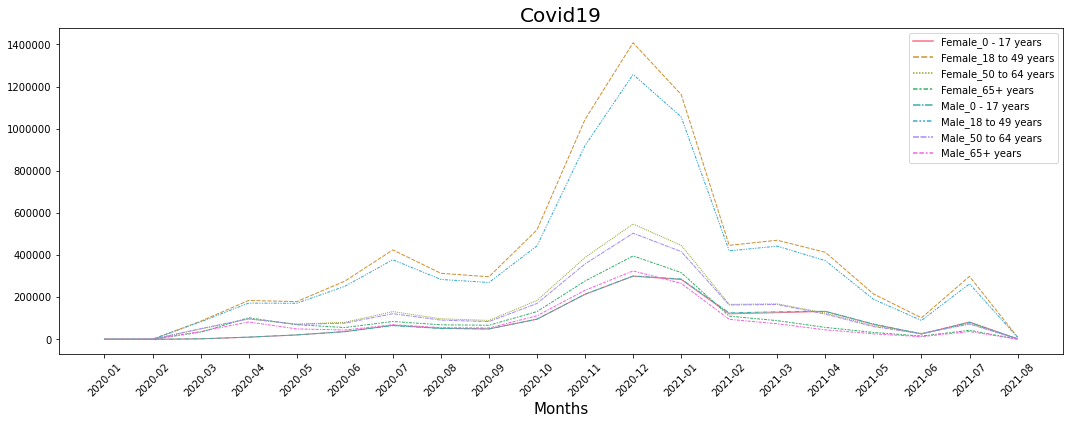

In [28]:
age_sex_data = pd.read_csv("age_sex_data_group_by.csv")
age_sex_data = age_sex_data.rename({"sex_age":"Month"}, axis='columns')
age_sex_data = age_sex_data.set_index('Month')

plt.figure(figsize=(18,6))
plt.ticklabel_format(style='plain')
plt.xticks(rotation=45)
b = sns.lineplot(data=age_sex_data, sort=True, linewidth=1,
            palette="husl")

b.axes.set_title("Covid19",fontsize=20)
b.set_xlabel('Months', fontsize=15)
#b.set_ylabel("Covid cases",fontsize=15)

#plt.savefig('Covid.png')

#### 3.2 Heavy symtom data ####

Text(0.5, 0, 'Months')

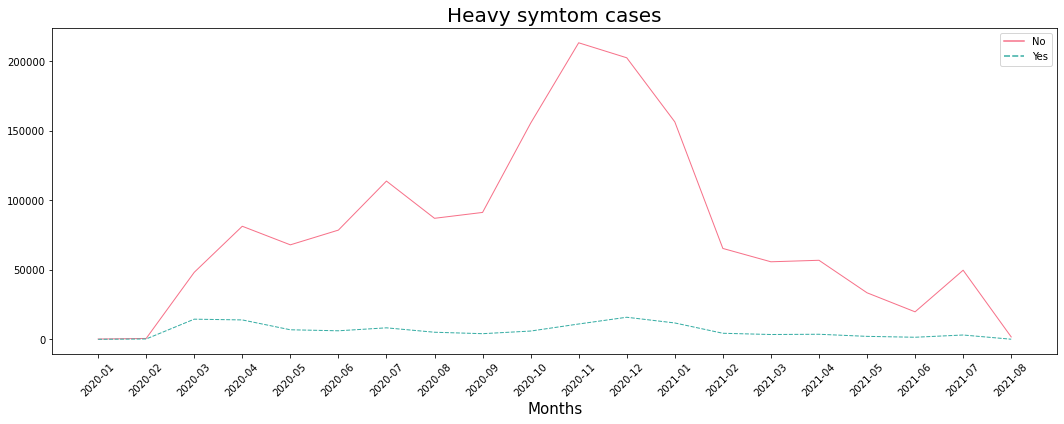

In [29]:
heavy_symtom_data = pd.read_csv("heavy_symtom_data_groupby.csv")
heavy_symtom_data = heavy_symtom_data.rename({"icu_yn":"Month"}, axis='columns')
heavy_symtom_data = heavy_symtom_data.set_index('Month')

plt.figure(figsize=(18,6))
plt.ticklabel_format(style='plain')
plt.xticks(rotation=45)
b = sns.lineplot(data=heavy_symtom_data, sort=True, linewidth=1,
            palette="husl")
b.axes.set_title("Heavy symtom cases",fontsize=20)
b.set_xlabel('Months', fontsize=15)

#plt.savefig('Heavy_symtom.png')

In [30]:
heavy_symtom_data = pd.read_csv("heavy_symtom_data_groupby.csv")
heavy_symtom_data = heavy_symtom_data.rename({"icu_yn":"Month"}, axis='columns')
heavy_symtom_data = heavy_symtom_data.set_index('Month')

# Slice month index and patients status
months = heavy_symtom_data.index
heavy_symtom_data = heavy_symtom_data.reset_index(drop=True)
Heavy = heavy_symtom_data['Yes']
Not_Heavy = heavy_symtom_data['No']

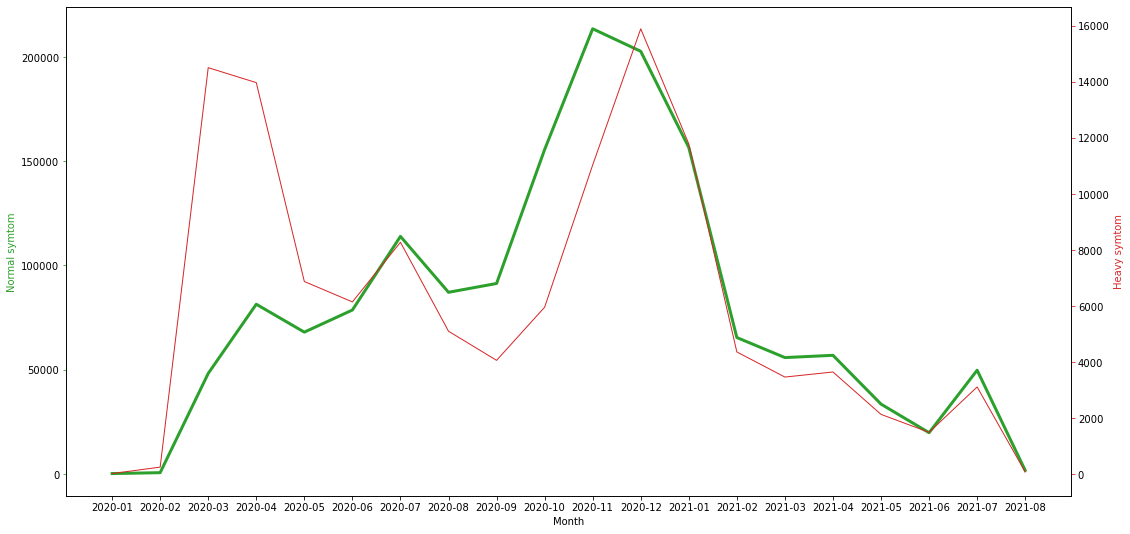

In [31]:
fig, ax1 = plt.subplots(figsize=(18,9))

color = 'tab:green'
ax1.set_xlabel("Month")
ax1.set_ylabel("Normal symtom", color = color)
ax1 = sns.lineplot(x = months, y = Not_Heavy, sort=True, linewidth=3,
                  color = color)
paltte = 'summer'
ax1.tick_params(axis='y', color = color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Heavy symtom", color = color)
ax2 = sns.lineplot(x = months, y = Heavy, sort=True, linewidth=1,
            color = color)
ax2.tick_params(axis='y', color = color)

plt.show()

done - change preprocessing step 
done - visualization (use two y axis for heavy symtom data)
done - heavy symtom preprocessing 

#### 3.3 States data ####

In [19]:
states_data = pd.read_csv("states_data_groupby.csv")
states_data = states_data.rename({"res_state":"Month"}, axis='columns')
states_data = states_data.set_index('Month')

states_data = states_data.fillna(0)
#states_data = states_data.astype(int)

states_data = states_data.T
states_data.iloc[2]

Month
2020-01        0.0
2020-02        0.0
2020-03     1057.0
2020-04     2573.0
2020-05     4711.0
2020-06    14480.0
2020-07    20900.0
2020-08    17437.0
2020-09    18803.0
2020-10    22654.0
2020-11    39392.0
2020-12    52464.0
2021-01    44109.0
2021-02    12479.0
2021-03     4473.0
2021-04     3658.0
2021-05     3655.0
2021-06     6144.0
2021-07    27400.0
2021-08      960.0
Name: AR, dtype: float64

In [3]:
data = pd.read_csv("time_series_covid19_confirmed_global.csv")
data = data.groupby('Country/Region').sum()

data = data.drop(columns = ['Lat', "Long"])

In [23]:
data

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,8/29/21,8/30/21,8/31/21,9/1/21,9/2/21,9/3/21,9/4/21,9/5/21,9/6/21,9/7/21
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,152960,153148,153220,153260,153306,153375,153375,153375,153534,153626
Albania,0,0,0,0,0,0,0,0,0,0,...,144847,145333,146387,147369,148222,149117,150101,150997,151499,152239
Algeria,0,0,0,0,0,0,0,0,0,0,...,195162,195574,196080,196527,196915,197308,197659,198004,198313,198645
Andorra,0,0,0,0,0,0,0,0,0,0,...,15025,15032,15033,15046,15052,15055,15055,15055,15069,15070
Angola,0,0,0,0,0,0,0,0,0,0,...,47168,47331,47544,47781,48004,48261,48475,48656,48790,49114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,0,2,2,2,2,2,2,2,2,2,...,435265,449489,462096,473530,486727,501649,511170,524307,536788,550996
West Bank and Gaza,0,0,0,0,0,0,0,0,0,0,...,337405,339816,342282,344957,347730,350224,351809,353732,356474,359236
Yemen,0,0,0,0,0,0,0,0,0,0,...,7784,7829,7869,7900,7951,8018,8056,8108,8142,8181


verify all process

find a way to connect power BI and FLASK